In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^IXIC'  # Nasdaq
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_nas.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(13479, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,4.605170,1.0,1.008400,1.008400
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,4.613535,1.0,0.999207,0.999207
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,4.612741,1.0,0.999305,0.999305
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,4.612047,1.0,1.007548,1.007548
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,4.619566,1.0,1.005914,1.005914
1971-02-12,102.050003,102.050003,102.050003,102.050003,102.050003,4.625463,1.0,1.001372,1.001372
1971-02-16,102.190002,102.190002,102.190002,102.190002,102.190002,4.626834,1.0,0.995596,0.995596
1971-02-17,101.739998,101.739998,101.739998,101.739998,101.739998,4.622421,1.0,0.996855,0.996855
1971-02-18,101.419998,101.419998,101.419998,101.419998,101.419998,4.619270,1.0,0.992901,0.992901


In [3]:
df.high[(df.high != df.low)]

Date
1984-10-11      244.699997
1984-10-12      246.199997
1984-10-15      247.699997
1984-10-16      247.899994
1984-10-17      247.100006
                  ...     
2024-07-15    18641.529297
2024-07-16    18576.830078
2024-07-17    18223.240234
2024-07-18    18130.869141
2024-07-19    17935.140625
Name: high, Length: 10020, dtype: float64

In [4]:
SIM_START = pd.to_datetime('1984-10-11')  # first day of legit open/close values
SIM_START

Timestamp('1984-10-11 00:00:00')

In [5]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'linear']), #'ma', 'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [6]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [7]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

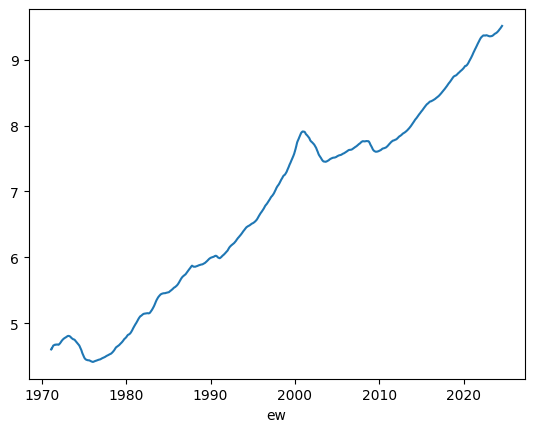

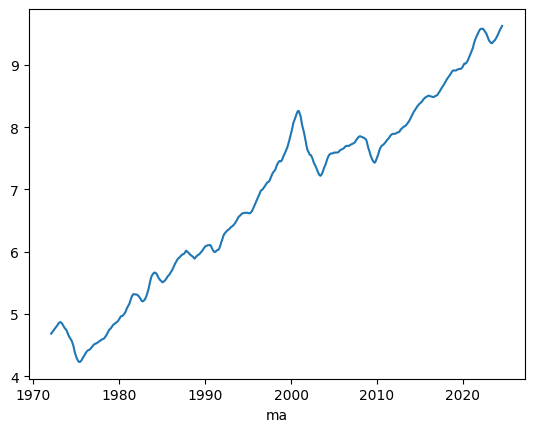

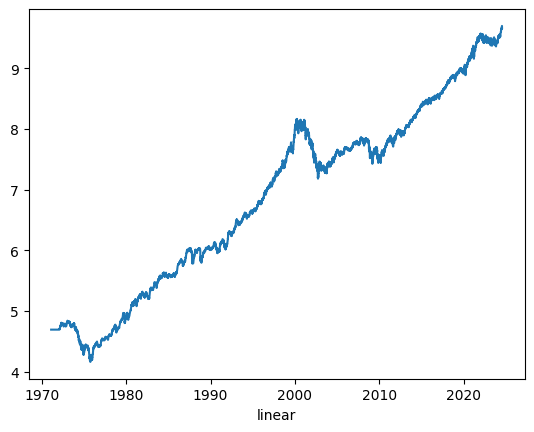

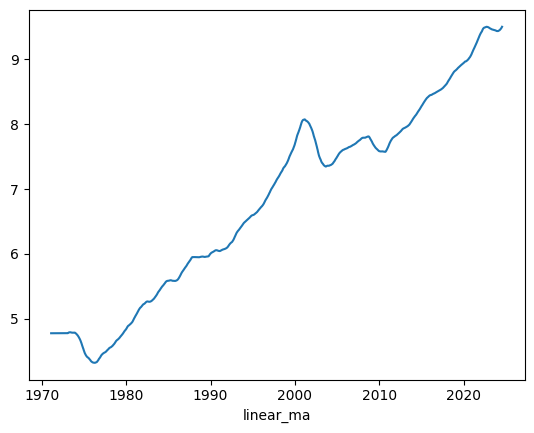

In [8]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [9]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [10]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [11]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [12]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [13]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [14]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(3712.7795551885692,
 {'time_param': 7,
  'method': 'linear',
  't': 0.576903484660976,
  'k': 9.813588625881824,
  'as_q': False,
  'transform_f': 'bounded_curve'})

Do nothing res: 72.4435622157957
Round 1: 3661.672896859833
New best: 3661.672896859833
{'time_param': 7, 'method': 'linear', 't': 0.576903484660976, 'k': 9.813588625881824, 'as_q': False, 'transform_f': 'bounded_curve'}


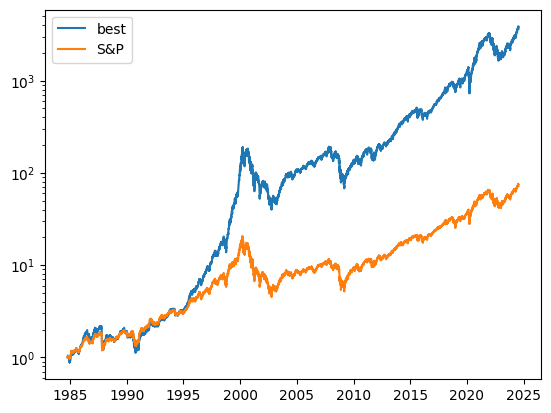

Round 2: 1.697071088688311
Round 3: 3850.813562841408
New best: 3850.813562841408
{'time_param': 95, 'method': 'ew', 't': 0.9783924824206374, 'k': 8.272205876778154, 'as_q': False, 'transform_f': 'bounded_curve'}


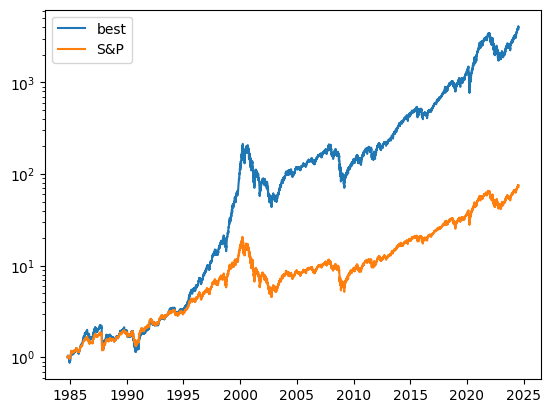

Round 4: 0.8569565152503958
Round 5: 12.832896865080777
Round 6: 61.57896717439919
Round 7: 1461.519788308182
Round 8: 123.66590746906158
Round 9: 41.538452599603765
Round 10: 128.40668098658236
Round 11: 2.598776619214381
Round 12: 35.7076091112871
Round 13: 166.29611246838078
Round 14: 3.750947700811224
Round 15: 3.1462405685587944
Round 16: 708.6638752638361
Round 17: 1.3187016688860052
Round 18: 339.4075270117294
Round 19: 9.91464854608052
Round 20: 1022.4160973979147
Round 21: 406.37015060573015
Round 22: 2.053029049960679
Round 23: 2856.033630423166
Round 24: 1837.6353321663064
Round 25: 529.3723124192112
Round 26: 1.9768675434163858
Round 27: 17.545206523506693
Round 28: 2592.0206069806645
Round 29: 198.22838652018686
Round 30: 5.078002648528776
Round 31: 47.46809035467352
Round 32: 164.1844948953174
Round 33: 1.1500133200128857
Round 34: 58.25589208676135
Round 35: 2.2895162700597917
Round 36: 1.4126272437494858
Round 37: 1.745267198003691
Round 38: 51.64406466002829
Round 39: 

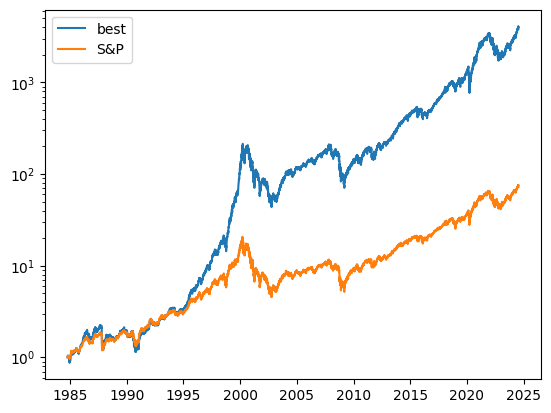

Round 75: 2.98647583733047
Round 76: 18.799009188223586
Round 77: 6.841996354066747
Round 78: 52.62488989151518
Round 79: 1.6254977075292907
Round 80: 1984.4576413080342
Round 81: 704.1834900339534
Round 82: 3711.4953499907288
Round 83: 3526.976924045015
Round 84: 6.869878127750674
Round 85: 1.0906228405316782
Round 86: 1.2212228611821234
Round 87: 777.9301858388666
Round 88: 2568.1308940709246
Round 89: 42.038458434988996
Round 90: 46.584304086037186
Round 91: 67.33527528086732
Round 92: 1.769706072494769
Round 93: 492.43796812672383
Round 94: 1.1824540511698487
Round 95: 1.25523437179708
Round 96: 1.445649152580271
Round 97: 1.451005622302174
Round 98: 89.3436003874442
Round 99: 618.4126736914247
Round 100: 42.85859997289013


In [15]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [17]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 72.4435622157957
Round 1: 2666.681256776412
Round 2: 300.8058995520598
Round 3: 3837.829800108659
Round 4: 3844.1620800922988
Round 5: 3837.8272031109
Round 6: 2887.4598902620482
Round 7: 3487.1660548445443
Round 8: 1578.5692932231498
Round 9: 2665.1140793172467
Round 10: 3837.831997038244

Factor: 1.03125
Do nothing res: 72.4435622157957
Round 1: 3837.829550945442
Round 2: 3134.36584123889
Round 3: 3837.836313242965
Round 4: 1340.1226922588312
Round 5: 3837.8236133909004
Round 6: 3837.826698069042
Round 7: 76.73590697893573
Round 8: 782.8542023486482
Round 9: 2749.490982431774
Round 10: 3837.834761879717

Factor: 1.015625
Do nothing res: 72.4435622157957
Round 1: 1543.623024335275
Round 2: 3837.830418597016
Round 3: 113.85680665875387
Round 4: 3649.0403616136405
Round 5: 2657.696017647207
Round 6: 3837.831202790243
Round 7: 1667.6596913312528
Round 8: 900.511368304839
Round 9: 3837.831362920658
Round 10: 3078.6044509677736

Factor: 1.0078125
Do nothing r

In [32]:
# Force set:
#best_out =  3661.672896859833
#params_out = {'time_param': 7, 'method': 'linear', 't': 0.576903484660976, 'k': 9.813588625881824, 'as_q': False, 'transform_f': 'bounded_curve'}

In [33]:
final_out = simulate(df, params_out)

In [34]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9975388596523571

In [35]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6152169924825966

In [36]:
params_out

{'time_param': 7,
 'method': 'linear',
 't': 0.576903484660976,
 'k': 9.813588625881824,
 'as_q': False,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


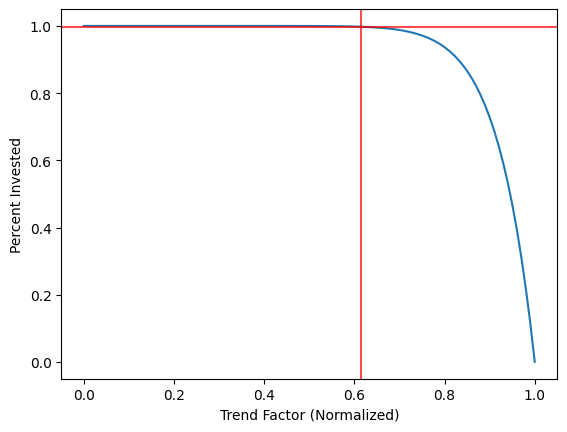

In [37]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

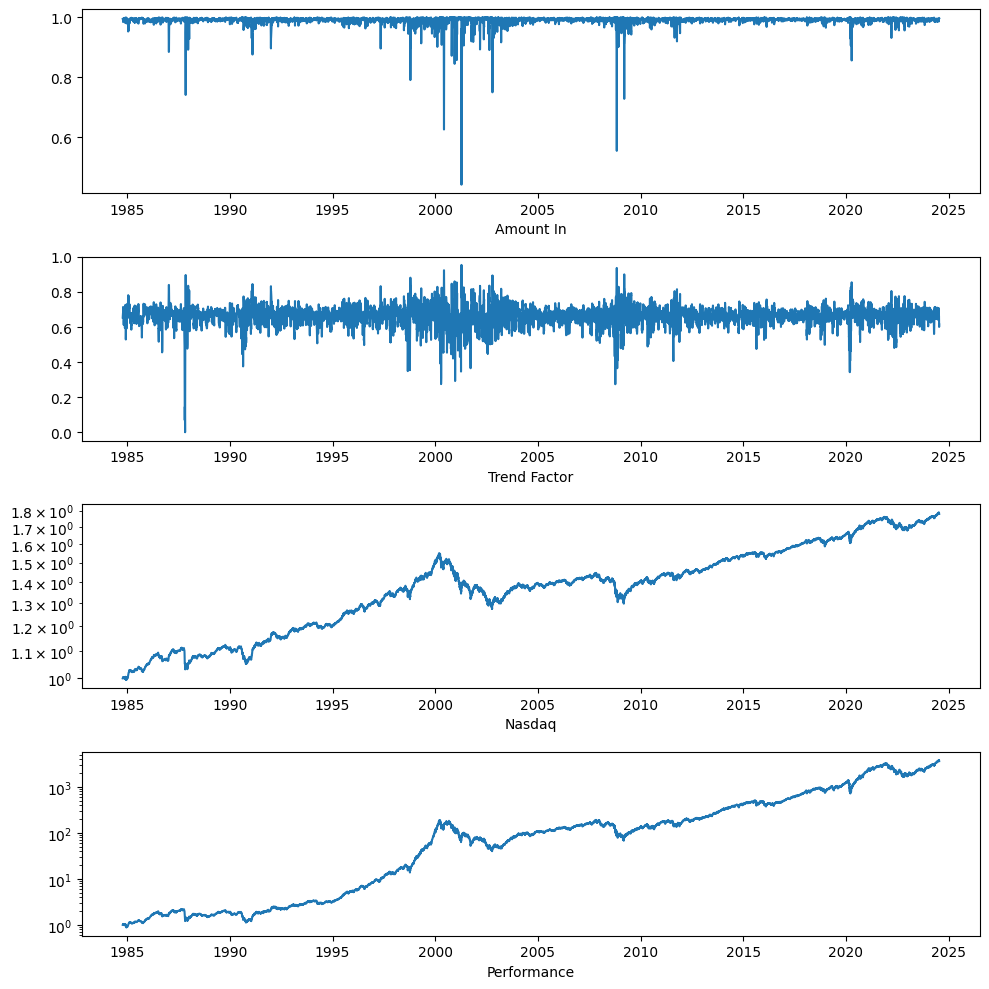

In [38]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [39]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Nasdaq')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

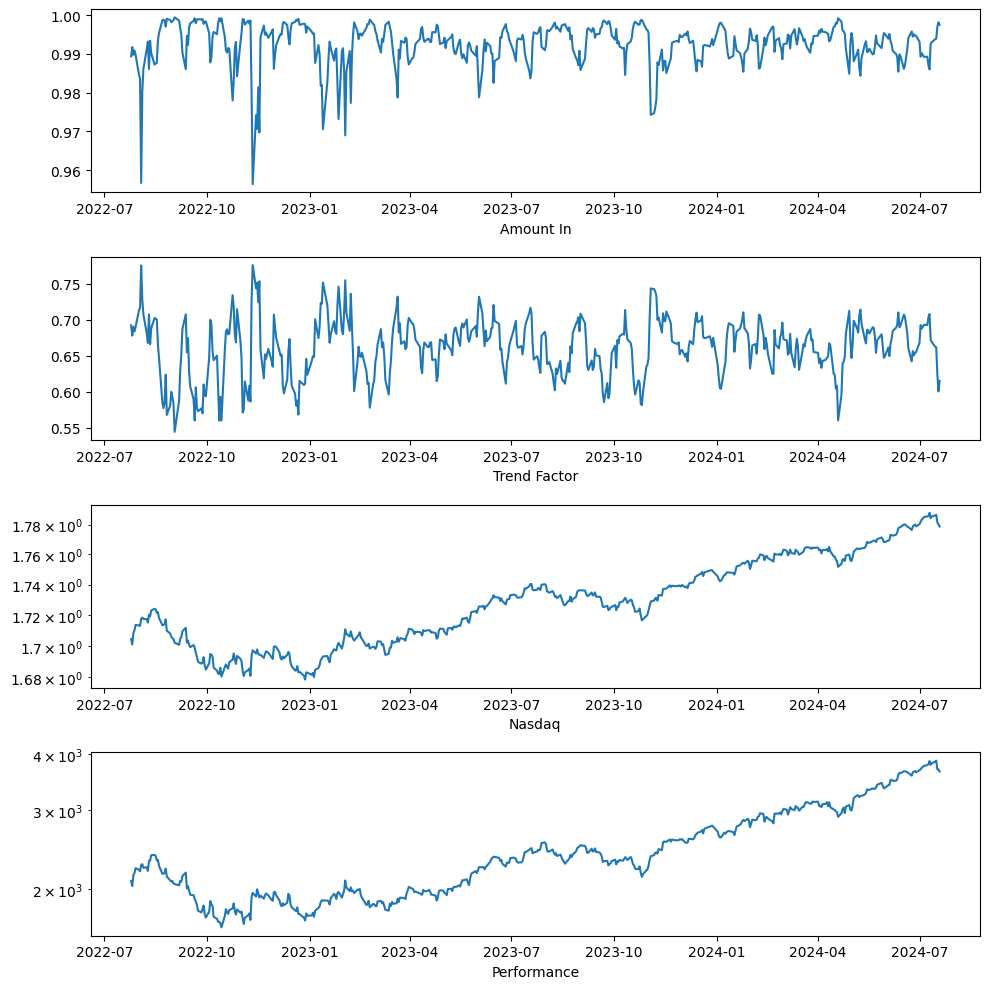

In [40]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [41]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9975

In [42]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(244.6999969482422, 40.088, 17726.939453125)

In [43]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.22714650981235507

In [44]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['nas'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1172784578315471, 1.0], 'nas': [1.227146509812355, 0.9975], 'rus': [1.2680366015016034, 1.0], 'jpxn': [1.0672252720640971, 0.0], 'ktec': [1.6599402811386, 0.0], 'emb': [1.0683946681306238, 1.0], 'gdx': [1.335117830426835, 0.5092], 'dia': [1.2015064238720055, 1.0]}


In [45]:
stop

NameError: name 'stop' is not defined

In [46]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(3661.672896859833,
 {'time_param': 7,
  'method': 'linear',
  't': 0.576903484660976,
  'k': 9.813588625881824,
  'as_q': False,
  'transform_f': 'bounded_curve'})